## Problem 1

#### Import statements

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.signal as signal

#### Read the video and generate the background subtractor

In [10]:
vid = cv2.VideoCapture('./data/Q1.avi')
backgroundSubtractor = cv2.createBackgroundSubtractorMOG2(varThreshold=32, detectShadows=False)

#### Generate masks for first 10 frames of the video to identify the foreground

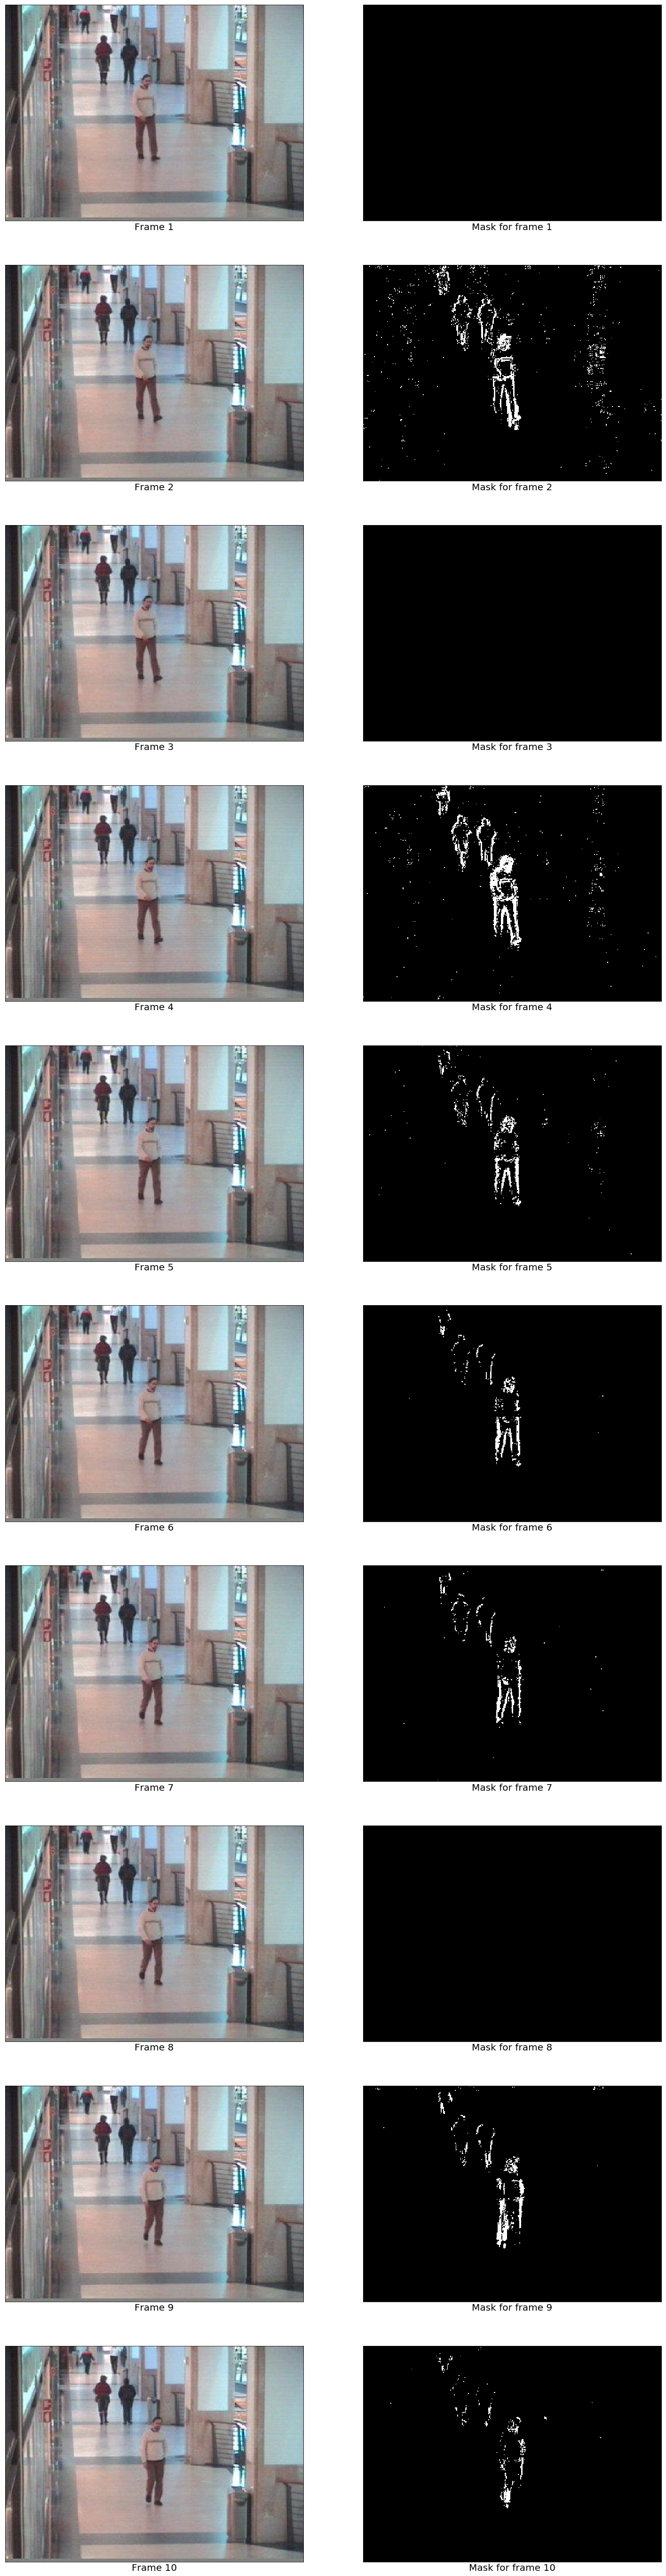

In [11]:
fig, axes = plt.subplots(10, 2, figsize=(25, 100))
for i in range(10):
    _, frame = vid.read()
    mask = backgroundSubtractor.apply(frame)
    ax = axes[i, 0]
    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Frame {}'.format(i+1), fontsize=20)
    ax = axes[i, 1]
    ax.imshow(mask, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Mask for frame {}'.format(i+1), fontsize=20)
plt.show()

#### Use dilation to easily identify the subject and find the largest contour to find location of subject

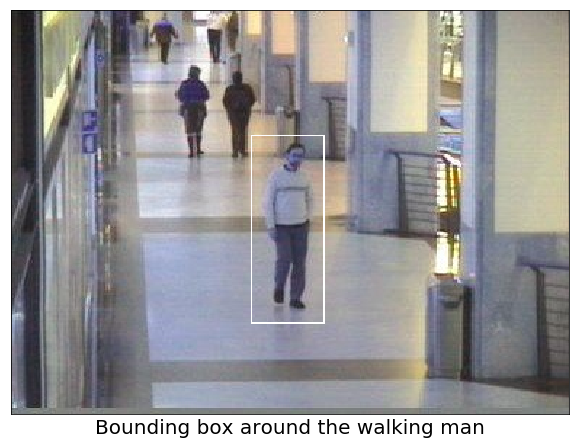

In [5]:
kernel = np.ones((5,5), np.uint8)
closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=3)
dilation = cv2.dilate(closing, kernel, iterations=3)
_, contours, _ = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = contours[np.argmax([cv2.contourArea(c) for c in contours])]
x, y, w, h = cv2.boundingRect(largest_contour)
template = frame[y: y+h, x: x+w]
plt.figure(figsize=(10, 12))
plt.imshow(cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 255, 255), 1))
plt.xlabel('Bounding box around the walking man', fontsize=20)
plt.xticks([])
plt.yticks([])
plt.show()

#### Track the subject in next 10 frames of the image using normalized cross correlation

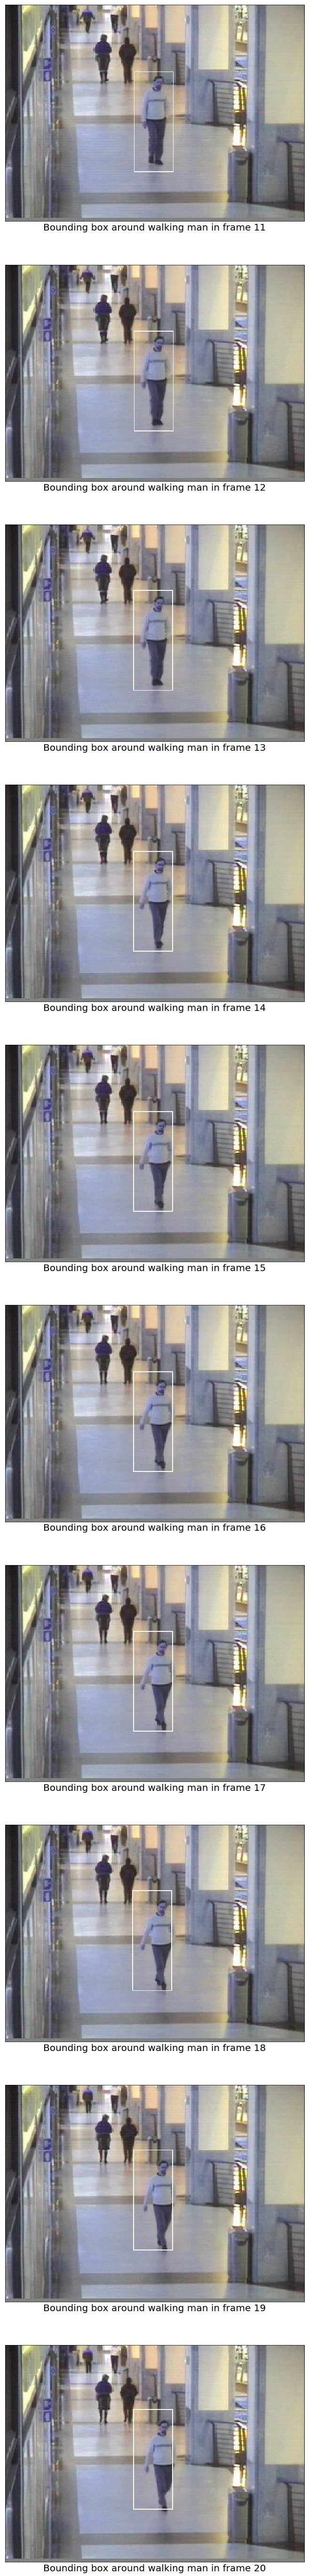

In [6]:
plt.figure(figsize=(15, 100))
for i in range(10):
    _, next_frame = vid.read()
    next_frame_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    next_frame_gray = next_frame_gray - next_frame_gray.mean()
    template_gray = template_gray - template_gray.mean()
    corr = signal.correlate2d(next_frame_gray, template_gray, mode='same', boundary='symm')
    y, x = np.unravel_index(np.argmax(corr), corr.shape)
    plt.subplot(10, 1, i+1)
    top_left = x - int(np.floor((w / 2)))
    bottom_left = y - int(np.floor((h / 2)))
    top_right = x + int(np.floor((w / 2)))
    bottom_right = y + int(np.floor((h / 2)))
    template = next_frame[bottom_left: bottom_right, top_left: top_right]
    plt.imshow(cv2.rectangle(next_frame, (top_left, bottom_left), (top_right, bottom_right), (255, 255, 255), 1))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Bounding box around walking man in frame {}'.format(i + 1 + 10), fontsize=20)
plt.show()
vid.release()